In [1]:
import numpy as np
import random
import time

import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib import cm

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from numba import vectorize, jit

%matplotlib inline

random.seed(30)
np.random.seed(seed=30)

print('check random: ', random.randint(0,100))
print('check numpy random: ', np.random.randint(0,100))


check random:  69
check numpy random:  37


In [2]:
#Some variables to calculate the velocity
W = 0.5
c1 = 0.015
c2 = 0.5

# variables tha control optimizer
iterations = 1000
target_error = 1e-5

# create population
n_dim = 2
# n_particles = 50
max_part = 100000
part_jump = 25000





In [3]:

#function that models the problem
target = 1
# @vectorize(['float32(float32, float32)'], target='parallel')
# @vectorize(['float32(float32, float32)'], target='cuda')
# @jit
def fitness_function_vec(a,b):
    return a**2 + b**2 + 1


#function that models the problem
target = 1
def fitness_function(position):
    return position[0]**2 + position[1]**2 + 1


#function that models the problem
target = 0
# @vectorize(['float32(float32, float32)'], target='parallel')
# @vectorize(['float32(float32, float32)'], target='cuda')
# @jit
def fitness_function_vec(a,b):
    A = 10
    f = 0
    
    f = f + a**2 + b**2 - A*np.cos(2*np.pi*a) - A*np.cos(2*np.pi*b)
    
#     for j in range(2):
#         f = f + position[j]**2 - A*np.cos(2*np.pi*position[j])
    return A*2 + f


#function that models the problem
target = 0
def fitness_function(position):
    A = 10
    f = 0
    for j in range(2):
        f = f + position[j]**2 - A*np.cos(2*np.pi*position[j])
    return A*2 + f

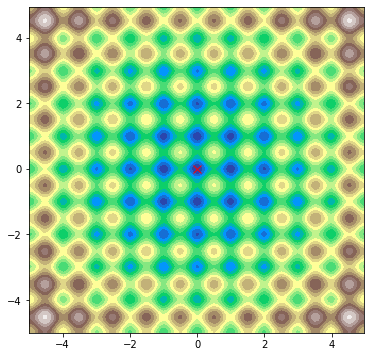

fitness: 0.0


In [4]:
delta = .05
x = np.arange(-5.0, 5.0, delta)
y = np.arange(-5.0, 5.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = fitness_function([X,Y])

fig, ax = plt.subplots(figsize=(6,6))
cmap = cm.get_cmap(name='terrain', lut=None)
# cmap = cm.get_cmap(name='viridis', lut=None)

CS = ax.contourf(X, Y, Z1, 19, cmap=cmap)

plt.plot(0,0, 'rx', markersize=8)

plt.show()

print('fitness:',fitness_function([0,0]))

In [5]:
pbest = np.array([10,11,10,10], dtype=np.float32)
fitness = np.array([9,12,10,11], dtype=np.float32)

print('old pbest', pbest)

adjusted_fitness_ind = fitness < pbest
print(adjusted_fitness_ind)

original_value_ind = fitness >= pbest
print(original_value_ind)


pbest = original_value_ind*pbest + adjusted_fitness_ind*fitness
print('new pbest', pbest)


fitness = np.array([8,10,7,11], dtype=np.float32)

print('old pbest', pbest)

adjusted_fitness_ind = fitness < pbest
print(adjusted_fitness_ind)

original_value_ind = fitness >= pbest
print(original_value_ind)


pbest = original_value_ind*pbest + adjusted_fitness_ind*fitness
print('new pbest', pbest)

pbest**2

old pbest [10. 11. 10. 10.]
[ True False False False]
[False  True  True  True]
new pbest [ 9. 11. 10. 10.]
old pbest [ 9. 11. 10. 10.]
[ True  True  True False]
[False False False  True]
new pbest [ 8. 10.  7. 10.]


array([ 64., 100.,  49., 100.], dtype=float32)

In [6]:

def pso_vec(particle_position_vectora, particle_position_vectorb, 
            particle_velocity_vectora, particle_velocity_vectorb,
            pbest_fitness_value1, gbest_fitness_value1,
            W, c1, c2, target, n_iterations, target_error, n_particles, n_dim):
    
        
    iteration = 0

#     position_history = dict([(key, []) for key in range(n_particles)])
#     fitness_history = dict([(key, []) for key in range(n_particles)])

    t3 = time.time()
    
    run_convergence = []
    
    
    # start optimization procedure
    while iteration < n_iterations:
        
        
        fitness_cadidate1 = fitness_function_vec(np.ascontiguousarray(particle_position_vectora, dtype=np.float32), np.ascontiguousarray(particle_position_vectorb, dtype=np.float32))
#         fitness_cadidate1 = fitness_function_vec(particle_position_vectora, particle_position_vectorb)
#         print('fitness_cadidate1', fitness_cadidate1)

        adjusted_fitness_ind = fitness_cadidate1 < pbest_fitness_value1
#         print(adjusted_fitness_ind)
        original_value_ind = fitness_cadidate1 >= pbest_fitness_value1
#         print(original_value_ind)
        pbest_fitness_value1 = original_value_ind*pbest_fitness_value1 + adjusted_fitness_ind*fitness_cadidate1
#         print('new pbest', pbest_fitness_value1)
        
        # adjust only the improved positions
        particle_pbest_pos_vectora = original_value_ind*particle_position_vectora + adjusted_fitness_ind*particle_position_vectora
        particle_pbest_pos_vectorb = original_value_ind*particle_position_vectorb + adjusted_fitness_ind*particle_position_vectorb
#         print('\n\nparticle_position_vectora\n', particle_pbest_pos_vectora)
#         print('\nparticle_position_vectorb\n', particle_pbest_pos_vectorb)
        
        # check if has new global best
        gadjusted_fitness_ind = fitness_cadidate1 <= gbest_fitness_value1
#         print('gadjusted_fitness_ind', gadjusted_fitness_ind)
        majorar_gadjusted_fitness_ind = fitness_cadidate1 > gbest_fitness_value1
#         print('gadjusted_fitness_ind', gadjusted_fitness_ind)
        
        # if has take value and position
        if gadjusted_fitness_ind.any() == True:
            
            # adjust values bigger than old solution to a really big number (in order to discard on minimization)
            minimum_candidates = majorar_gadjusted_fitness_ind*fitness_cadidate1*1e12 + gadjusted_fitness_ind*fitness_cadidate1
#             print('minimum_candidates', minimum_candidates)
            minimum_from_candidates = np.min(minimum_candidates)
#             print('minimum_from_candidates', minimum_from_candidates)
            
            # set the new minimum
            gbest_fitness_value1 = minimum_from_candidates
            
            # take the index of best solution to find the position (ASSUMED TO USE THE FIRST VALUE)
            gbest_fitness_value_ind = np.where(fitness_cadidate1 == minimum_from_candidates)[0][0]
#             print('111 gbest_fitness_value1_ind', gbest_fitness_value_ind)
    
            # set the new best position
            particle_gbest_pos_vectora = particle_pbest_pos_vectora[gbest_fitness_value_ind]
            particle_gbest_pos_vectorb = particle_pbest_pos_vectorb[gbest_fitness_value_ind]
        
        
        if(abs(gbest_fitness_value1 - target) < target_error):
            break

        # update position and velocity
        new_particle_velocity_vectora = (W*particle_velocity_vectora) + (c1*random.random()) * (particle_pbest_pos_vectora - particle_position_vectora) + (c2*random.random()) * (particle_gbest_pos_vectora - particle_position_vectora)
        new_particle_velocity_vectorb = (W*particle_velocity_vectorb) + (c1*random.random()) * (particle_pbest_pos_vectorb - particle_position_vectorb) + (c2*random.random()) * (particle_gbest_pos_vectorb - particle_position_vectorb)

#         new_particle_position_vectora = particle_position_vectora + new_particle_velocity_vectora
#         new_particle_position_vectorb = particle_position_vectorb + new_particle_velocity_vectorb
#         particle_position_vectora = new_particle_position_vectora
#         particle_position_vectorb = new_particle_position_vectorb

        particle_position_vectora += new_particle_velocity_vectora
        particle_position_vectorb += new_particle_velocity_vectora

        run_convergence.append([iteration, gbest_fitness_value1])
    
        # move to next iteration
        iteration = iteration + 1

    t4 = time.time()
      
    
    sol_error = abs(gbest_fitness_value1 - target)
    
    opt_time  = t4 - t3
    
    print("\nThe best position is ", particle_gbest_pos_vectora, particle_gbest_pos_vectorb, "in iteration number ", iteration, " with value ", gbest_fitness_value1, " and error ", sol_error)
    
    max_iteration = iteration
    
    run_metrics = [n_iterations, n_particles, sol_error, max_iteration, opt_time]
    
    
#     return position_history, fitness_history, run_metrics
    return particle_position_vectora, particle_position_vectorb, run_metrics, run_convergence


In [7]:

# random.seed(30)
# np.random.seed(seed=30)

# # create initial particles
# t1 = time.time()
# particle_position_vector = np.array([np.array([(-1) ** (bool(random.getrandbits(1))) * random.random()*5, (-1)**(bool(random.getrandbits(1))) * random.random()*5]) for _ in range(10)], dtype=np.float32)
# #     particle_position_vector
# pbest_position = particle_position_vector
# #     pbest_fitness_value = np.array([float('inf') for _ in range(n_particles)], dtype=np.float32)
# #     pbest_fitness_value = np.array([999999. for _ in range(n_particles)], dtype=np.float32)
# pbest_fitness_value1 = np.array([999999. for _ in range(10)], dtype=np.float32)
# #     gbest_fitness_value = float('inf')
# # gbest_fitness_value = 999999.
# gbest_fitness_value1 = 999999.
# #     gbest_position = np.array([float('inf'), float('inf')])
# gbest_position = np.array([999999., 999999.])

# velocity_vector = np.array([np.array([0., 0.], dtype=np.float32) for _ in range(10)], dtype=np.float32)
# t2 = time.time()

# # list_gbest_pos = []
# #     list_gbest_val = []

# # list_fit_cand = []

# particle_position_vectora = particle_position_vector[:,0]
# particle_position_vectorb = particle_position_vector[:,1]


# particle_velocity_vectora = velocity_vector[:,0]
# particle_velocity_vectorb = velocity_vector[:,1]

# (position_a_def,
#  position_b_def,
#  run_metrics_def,
#  convergence_def) = pso_vec(particle_position_vectora, particle_position_vectorb, 
#                                 particle_velocity_vectora, particle_velocity_vectorb,
#                                 pbest_fitness_value1, gbest_fitness_value1, 
#                                 W, c1, c2, target, 100, target_error, 20, n_dim)

In [8]:

range_particles = np.arange(0, max_part+1, part_jump)
range_particles = np.delete(range_particles, 0)
range_particles = np.insert(range_particles, 0, 10)
range_particles

comparative_metrics_def = []
comparative_convergence_def = []

for n_part in range_particles:
    
    
    random.seed(30)
    np.random.seed(seed=30)

    # create initial particles
    t1 = time.time()
    particle_position_vector = np.array([np.array([(-1) ** (bool(random.getrandbits(1))) * random.random()*5, (-1)**(bool(random.getrandbits(1))) * random.random()*5]) for _ in range(n_part)], dtype=np.float32)
    #     particle_position_vector
    pbest_position = particle_position_vector
    #     pbest_fitness_value = np.array([float('inf') for _ in range(n_particles)], dtype=np.float32)
    #     pbest_fitness_value = np.array([999999. for _ in range(n_particles)], dtype=np.float32)
    pbest_fitness_value1 = np.array([999999. for _ in range(n_part)], dtype=np.float32)
    #     gbest_fitness_value = float('inf')
    # gbest_fitness_value = 999999.
    gbest_fitness_value1 = 999999.
    #     gbest_position = np.array([float('inf'), float('inf')])
    gbest_position = np.array([999999., 999999.])

    velocity_vector = np.array([np.array([0., 0.], dtype=np.float32) for _ in range(n_part)], dtype=np.float32)
    t2 = time.time()

    # list_gbest_pos = []
#     list_gbest_val = []
    
    # list_fit_cand = []

    particle_position_vectora = particle_position_vector[:,0]
    particle_position_vectorb = particle_position_vector[:,1]


    particle_velocity_vectora = velocity_vector[:,0]
    particle_velocity_vectorb = velocity_vector[:,1]
    

    (position_a_def,
     position_b_def,
     run_metrics_def,
     convergence_def) = pso_vec(particle_position_vectora, particle_position_vectorb, 
                                    particle_velocity_vectora, particle_velocity_vectorb,
                                    pbest_fitness_value1, gbest_fitness_value1, 
                                    W, c1, c2, target, iterations, target_error, n_part, n_dim)
    
    comparative_metrics_def.append(run_metrics_def)
    comparative_convergence_def.append(convergence_def)



The best position is  0.10451456 -0.82424426 in iteration number  1000  with value  8.272547  and error  8.272546768188477

The best position is  -0.00017584156 0.00035011017 in iteration number  1000  with value  3.0517578e-05  and error  3.0517578125e-05

The best position is  -0.000104481056 0.00017399184 in iteration number  34  with value  7.6293945e-06  and error  7.62939453125e-06

The best position is  -0.000119550066 -1.8699022e-05 in iteration number  28  with value  3.8146973e-06  and error  3.814697265625e-06

The best position is  0.00015951763 -1.1764932e-06 in iteration number  26  with value  3.8146973e-06  and error  3.814697265625e-06


In [9]:

#function that models the problem
target = 1
# @vectorize(['float32(float32, float32)'], target='parallel')
# @vectorize(['float32(float32, float32)'], target='cuda')
@jit
def fitness_function_vec(a,b):
    return a**2 + b**2 + 1


#function that models the problem
target = 1
def fitness_function(position):
    return position[0]**2 + position[1]**2 + 1



#function that models the problem
target = 0
# @vectorize(['float32(float32, float32)'], target='parallel')
# @vectorize(['float32(float32, float32)'], target='cuda')
@jit
def fitness_function_vec(a,b):
    A = 10
    f = 0
    
    f = f + a**2 + b**2 - A*np.cos(2*np.pi*a) - A*np.cos(2*np.pi*b)
    
#     for j in range(2):
#         f = f + position[j]**2 - A*np.cos(2*np.pi*position[j])
    return A*2 + f


#function that models the problem
target = 0
def fitness_function(position):
    A = 10
    f = 0
    for j in range(2):
        f = f + position[j]**2 - A*np.cos(2*np.pi*position[j])
    return A*2 + f

In [10]:

range_particles = np.arange(0, max_part+1, part_jump)
range_particles = np.delete(range_particles, 0)
range_particles = np.insert(range_particles, 0, 10)
range_particles

comparative_metrics_jit = []
comparative_convergence_jit = []


for n_part in range_particles:
    
    
    random.seed(30)
    np.random.seed(seed=30)

    # create initial particles
    t1 = time.time()
    particle_position_vector = np.array([np.array([(-1) ** (bool(random.getrandbits(1))) * random.random()*5, (-1)**(bool(random.getrandbits(1))) * random.random()*5]) for _ in range(n_part)], dtype=np.float32)
    #     particle_position_vector
    pbest_position = particle_position_vector
    #     pbest_fitness_value = np.array([float('inf') for _ in range(n_particles)], dtype=np.float32)
    #     pbest_fitness_value = np.array([999999. for _ in range(n_particles)], dtype=np.float32)
    pbest_fitness_value1 = np.array([999999. for _ in range(n_part)], dtype=np.float32)
    #     gbest_fitness_value = float('inf')
    # gbest_fitness_value = 999999.
    gbest_fitness_value1 = 999999.
    #     gbest_position = np.array([float('inf'), float('inf')])
    gbest_position = np.array([999999., 999999.])

    velocity_vector = np.array([np.array([0., 0.], dtype=np.float32) for _ in range(n_part)], dtype=np.float32)
    t2 = time.time()

    # list_gbest_pos = []
    # list_gbest_val = []
    # list_fit_cand = []

    particle_position_vectora = particle_position_vector[:,0]
    particle_position_vectorb = particle_position_vector[:,1]


    particle_velocity_vectora = velocity_vector[:,0]
    particle_velocity_vectorb = velocity_vector[:,1]
    

    (position_a_jit,
     position_b_jit,
     run_metrics_jit,
     convergence_jit) = pso_vec(particle_position_vectora, particle_position_vectorb, 
                                    particle_velocity_vectora, particle_velocity_vectorb,
                                    pbest_fitness_value1, gbest_fitness_value1, 
                                    W, c1, c2, target, iterations, target_error, n_part, n_dim)
    
    comparative_metrics_jit.append(run_metrics_jit)
    comparative_convergence_jit.append(convergence_jit)



The best position is  0.10451456 -0.82424426 in iteration number  1000  with value  8.272549327925761  and error  8.272549327925761

The best position is  -0.00017584156 0.00035011017 in iteration number  1000  with value  3.045265706091982e-05  and error  3.045265706091982e-05

The best position is  -0.000104481056 0.00017399184 in iteration number  34  with value  8.171660404343584e-06  and error  8.171660404343584e-06

The best position is  -0.000119550066 -1.8699022e-05 in iteration number  28  with value  2.904831383432338e-06  and error  2.904831383432338e-06

The best position is  -0.0001379796 -3.7128542e-05 in iteration number  26  with value  4.050550991507862e-06  and error  4.050550991507862e-06


In [11]:
import math

#function that models the problem
target = 1
# @vectorize(['float32(float32, float32)'], target='parallel')
@vectorize(['float32(float32, float32)'], target='cuda')
# @jit
def fitness_function_vec(a,b):
    return a**2 + b**2 + 1


#function that models the problem
target = 1
def fitness_function(position):
    return position[0]**2 + position[1]**2 + 1



#function that models the problem
target = 0
# @vectorize(['float32(float32, float32)'], target='parallel')
@vectorize(['float32(float32, float32)'], target='cuda')
# @jit
def fitness_function_vec(a,b):
    A = 10
    f = 0
    
    f = f + a**2 + b**2 - A*math.cos(2*np.pi*a) - A*math.cos(2*np.pi*b)
    
#     for j in range(2):
#         f = f + position[j]**2 - A*np.cos(2*np.pi*position[j])
    return A*2 + f


#function that models the problem
target = 0
def fitness_function(position):
    A = 10
    f = 0
    for j in range(2):
        f = f + position[j]**2 - A*np.cos(2*np.pi*position[j])
    return A*2 + f

In [12]:

range_particles = np.arange(0, max_part+1, part_jump)
range_particles = np.delete(range_particles, 0)
range_particles = np.insert(range_particles, 0, 10)
range_particles

comparative_metrics_cuda = []
comparative_convergence_cuda = []


for n_part in range_particles:
    
    
    random.seed(30)
    np.random.seed(seed=30)

    # create initial particles
    t1 = time.time()
    particle_position_vector = np.array([np.array([(-1) ** (bool(random.getrandbits(1))) * random.random()*5, (-1)**(bool(random.getrandbits(1))) * random.random()*5]) for _ in range(n_part)], dtype=np.float32)
    #     particle_position_vector
    pbest_position = particle_position_vector
    #     pbest_fitness_value = np.array([float('inf') for _ in range(n_particles)], dtype=np.float32)
    #     pbest_fitness_value = np.array([999999. for _ in range(n_particles)], dtype=np.float32)
    pbest_fitness_value1 = np.array([999999. for _ in range(n_part)], dtype=np.float32)
    #     gbest_fitness_value = float('inf')
    # gbest_fitness_value = 999999.
    gbest_fitness_value1 = 999999.
    #     gbest_position = np.array([float('inf'), float('inf')])
    gbest_position = np.array([999999., 999999.])

    velocity_vector = np.array([np.array([0., 0.], dtype=np.float32) for _ in range(n_part)], dtype=np.float32)
    t2 = time.time()

    # list_gbest_pos = []
    # list_gbest_val = []
    # list_fit_cand = []

    particle_position_vectora = particle_position_vector[:,0]
    particle_position_vectorb = particle_position_vector[:,1]


    particle_velocity_vectora = velocity_vector[:,0]
    particle_velocity_vectorb = velocity_vector[:,1]
    
    
    (position_a_cuda,
     position_b_cuda,
     run_metrics_cuda,
     convergence_cuda) = pso_vec(particle_position_vectora, particle_position_vectorb, 
                                    particle_velocity_vectora, particle_velocity_vectorb,
                                    pbest_fitness_value1, gbest_fitness_value1, 
                                    W, c1, c2, target, iterations, target_error, n_part, n_dim)
    
    comparative_metrics_cuda.append(run_metrics_cuda)
    comparative_convergence_cuda.append(convergence_cuda)



The best position is  0.10451456 -0.82424426 in iteration number  1000  with value  8.27255  and error  8.272549629211426

The best position is  -0.00017584156 0.00035011017 in iteration number  1000  with value  3.0452657e-05  and error  3.0452656574198045e-05

The best position is  -0.000104481056 0.00017399184 in iteration number  34  with value  8.171661e-06  and error  8.17166073829867e-06

The best position is  -0.000119550066 -1.8699022e-05 in iteration number  28  with value  2.9048315e-06  and error  2.9048314900137484e-06

The best position is  -0.0001379796 -3.7128542e-05 in iteration number  26  with value  4.050551e-06  and error  4.050551069667563e-06


In [13]:

#function that models the problem
target = 1
@vectorize(['float32(float32, float32)'], target='parallel')
# @vectorize(['float32(float32, float32)'], target='cuda')
# @jit
def fitness_function_vec(a,b):
    return a**2 + b**2 + 1


#function that models the problem
target = 1
def fitness_function(position):
    return position[0]**2 + position[1]**2 + 1



#function that models the problem
target = 0
@vectorize(['float32(float32, float32)'], target='parallel')
# @vectorize(['float32(float32, float32)'], target='cuda')
# @jit
def fitness_function_vec(a,b):
    A = 10
    f = 0
    
    f = f + a**2 + b**2 - A*np.cos(2*np.pi*a) - A*np.cos(2*np.pi*b)
    
#     for j in range(2):
#         f = f + position[j]**2 - A*np.cos(2*np.pi*position[j])
    return A*2 + f


#function that models the problem
target = 0
def fitness_function(position):
    A = 10
    f = 0
    for j in range(2):
        f = f + position[j]**2 - A*np.cos(2*np.pi*position[j])
    return A*2 + f

In [14]:

range_particles = np.arange(0, max_part+1, part_jump)
range_particles = np.delete(range_particles, 0)
range_particles = np.insert(range_particles, 0, 10)
range_particles

comparative_metrics_parall = []
comparative_convergence_parall = []


for n_part in range_particles:
    
    
    random.seed(30)
    np.random.seed(seed=30)

    # create initial particles
    t1 = time.time()
    particle_position_vector = np.array([np.array([(-1) ** (bool(random.getrandbits(1))) * random.random()*5, (-1)**(bool(random.getrandbits(1))) * random.random()*5]) for _ in range(n_part)], dtype=np.float32)
    #     particle_position_vector
    pbest_position = particle_position_vector
    #     pbest_fitness_value = np.array([float('inf') for _ in range(n_particles)], dtype=np.float32)
    #     pbest_fitness_value = np.array([999999. for _ in range(n_particles)], dtype=np.float32)
    pbest_fitness_value1 = np.array([999999. for _ in range(n_part)], dtype=np.float32)
    #     gbest_fitness_value = float('inf')
    # gbest_fitness_value = 999999.
    gbest_fitness_value1 = 999999.
    #     gbest_position = np.array([float('inf'), float('inf')])
    gbest_position = np.array([999999., 999999.])

    velocity_vector = np.array([np.array([0., 0.], dtype=np.float32) for _ in range(n_part)], dtype=np.float32)
    t2 = time.time()

    # list_gbest_pos = []
    # list_gbest_val = []
    # list_fit_cand = []

    particle_position_vectora = particle_position_vector[:,0]
    particle_position_vectorb = particle_position_vector[:,1]


    particle_velocity_vectora = velocity_vector[:,0]
    particle_velocity_vectorb = velocity_vector[:,1]
    
    
    (position_a_parall,
     position_b_parall,
     run_metrics_parall,
     convergence_parall) = pso_vec(particle_position_vectora, particle_position_vectorb, 
                                    particle_velocity_vectora, particle_velocity_vectorb,
                                    pbest_fitness_value1, gbest_fitness_value1, 
                                    W, c1, c2, target, iterations, target_error, n_part, n_dim)
    
    comparative_metrics_parall.append(run_metrics_parall)
    comparative_convergence_parall.append(convergence_parall)



The best position is  0.10451456 -0.82424426 in iteration number  1000  with value  8.27255  and error  8.272549629211426

The best position is  -0.00017584156 0.00035011017 in iteration number  1000  with value  3.0452657e-05  and error  3.0452656574198045e-05

The best position is  -0.000104481056 0.00017399184 in iteration number  34  with value  8.171661e-06  and error  8.17166073829867e-06

The best position is  -0.000119550066 -1.8699022e-05 in iteration number  28  with value  2.9048315e-06  and error  2.9048314900137484e-06

The best position is  -0.0001379796 -3.7128542e-05 in iteration number  26  with value  4.050551e-06  and error  4.050551069667563e-06


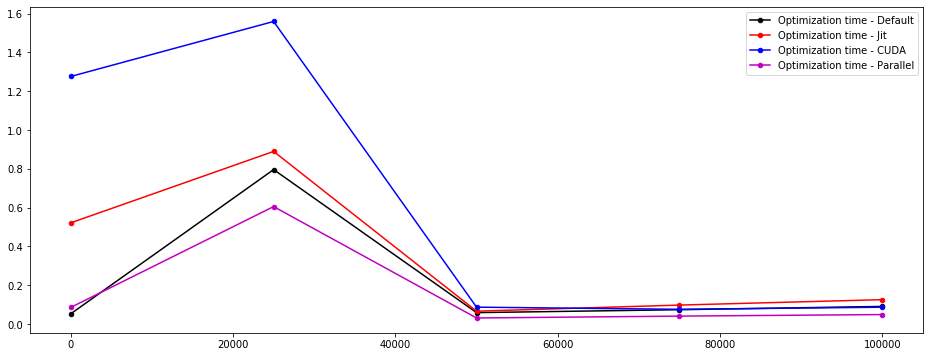

In [15]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(np.array(comparative_metrics_def)[:,1], np.array(comparative_metrics_def)[:,4], 'k-o', lw=1.5, markersize=4.5, label='Optimization time - Default')

ax.plot(np.array(comparative_metrics_jit)[:,1], np.array(comparative_metrics_jit)[:,4], 'r-o', lw=1.5, markersize=4.5, label='Optimization time - Jit')

ax.plot(np.array(comparative_metrics_cuda)[:,1], np.array(comparative_metrics_cuda)[:,4], 'b-o', lw=1.5, markersize=4.5, label='Optimization time - CUDA')

ax.plot(np.array(comparative_metrics_parall)[:,1], np.array(comparative_metrics_parall)[:,4], 'm-o', lw=1.5, markersize=4.5, label='Optimization time - Parallel')

ax.legend()
plt.show()


In [16]:
comparative_metrics_cuda

[[1000, 10, 8.272549629211426, 1000, 1.2759451866149902],
 [1000, 25000, 3.0452656574198045e-05, 1000, 1.5593643188476562],
 [1000, 50000, 8.17166073829867e-06, 34, 0.08697295188903809],
 [1000, 75000, 2.9048314900137484e-06, 28, 0.07596898078918457],
 [1000, 100000, 4.050551069667563e-06, 26, 0.08669900894165039]]

In [17]:
np.array(comparative_metrics_parall)[:,1]

array([1.0e+01, 2.5e+04, 5.0e+04, 7.5e+04, 1.0e+05])

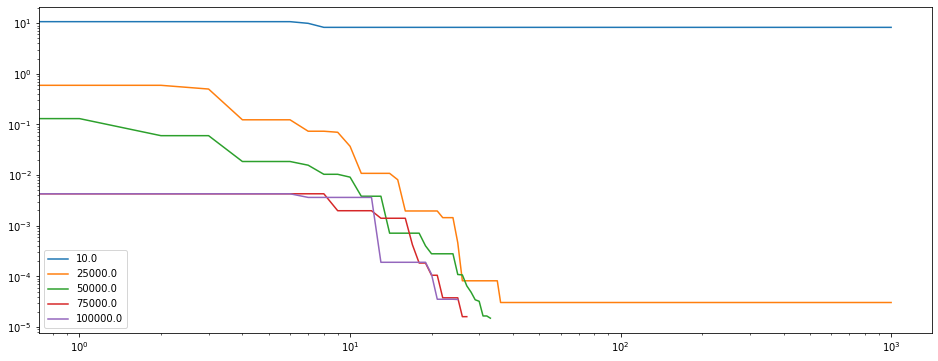

In [25]:
fig, ax = plt.subplots(figsize=(16,6))

for refinement in range(len(comparative_convergence_parall)):
    
#     plt.plot(comparative_convergence_parall[refinement])
    a = np.array(comparative_convergence_parall[refinement])
    
    iterations_run, gbest_run = np.hsplit(a, 2)
    ax.plot(iterations_run, gbest_run, label=str(np.array(comparative_metrics_parall)[refinement,1]))

ax.set_xscale(scale)
ax.set_yscale(scale)
ax.legend()
plt.show()



In [19]:
comparative_metrics_parall

[[1000, 10, 8.272549629211426, 1000, 0.0857698917388916],
 [1000, 25000, 3.0452656574198045e-05, 1000, 0.605353593826294],
 [1000, 50000, 8.17166073829867e-06, 34, 0.03125309944152832],
 [1000, 75000, 2.9048314900137484e-06, 28, 0.04089045524597168],
 [1000, 100000, 4.050551069667563e-06, 26, 0.048840999603271484]]

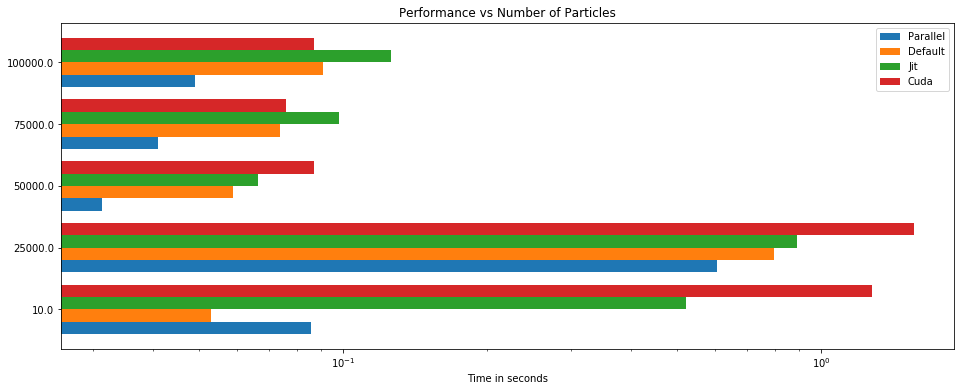

In [21]:
fig, ax = plt.subplots(figsize=(16,6))

# Example data
y_pos = np.arange(5)

linew = 0.2
scale = 'linear'
scale = 'log'


performance1 = np.array(comparative_metrics_parall)[:,4]
ax.barh(y_pos - linew/.666, performance1, linew, label='Parallel')

performance2 = np.array(comparative_metrics_def)[:,4]
ax.barh(y_pos - linew/2 , performance2, linew, label='Default')

performance3 = np.array(comparative_metrics_jit)[:,4]
ax.barh(y_pos + linew/2, performance3, linew, label='Jit')

performance4 = np.array(comparative_metrics_cuda)[:,4]
ax.barh(y_pos + linew/.666, performance4, linew, label='Cuda')

ax.set_xscale(scale)
ax.set_yticks(y_pos)
ax.set_yticklabels(np.array(comparative_metrics_parall)[:,1])
# ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Time in seconds')
ax.set_title('Performance vs Number of Particles')

ax.legend()
plt.show()

In [ ]:
np.array(comparative_metrics_parall)[:,1]

In [30]:
%%timeit
math.cos(np.pi)

119 ns ± 0.513 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [31]:
%%timeit
np.cos(np.pi)

618 ns ± 4.91 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
